In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_grouped_boxplots,plot_bars
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict

In [89]:
from util.consts import get_base_delay_path,get_base_delay_transmission
lr=10
dir_prev='/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test'
dir_curr='/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_debug'
for scenario_idx in [0]:
    sizes_prev=np.load(f'{dir_prev}/{scenario_idx}/ns3/fsize.npy')
    sizes_curr=np.load(f'{dir_curr}/{scenario_idx}/ns3/fsize.npy')[fid]
    print(f"{scenario_idx}: {sizes_prev.shape} {sizes_curr.shape}")
    fid=np.load(f'{dir_curr}/{scenario_idx}/ns3/fid_topology_flows.npy')
    fcts_gt=np.load(f'{dir_prev}/{scenario_idx}/ns3/fct_topology_flows.npy')
    fcts_i_gt=np.load(f'{dir_prev}/{scenario_idx}/ns3/fct_i_topology_flows.npy')
    
    dir_input_tmp=f'{dir_prev}/{scenario_idx}/ns3'
    link_list = np.load(
        f"{dir_input_tmp}/flink.npy",
    )
    link_dict = {link: idx for idx, link in enumerate(link_list)}
    link_info = np.load(
        f"{dir_input_tmp}/flow_to_path.npy",
        allow_pickle=True,
    )
    link_info = [[link_dict[link] for link in link_info[i]] for i in fid]

    flowid_to_linkid = defaultdict(list)
    edges_list = []
    for flow_idx in range(len(fid)):
        for link_idx in link_info[flow_idx]:
            edges_list.append([flow_idx, link_idx])
            flowid_to_linkid[flow_idx].append(link_idx)
    edges_list = np.array(edges_list).T

    n_links_passed = np.array([len(path) for path in link_info])
    base_delay = get_base_delay_path(sizes_prev, n_links_passed, lr)
    
    fcts_flowsim_prev=np.load(f'{dir_prev}/{scenario_idx}/ns3/flowsim_fct.npy')+base_delay
    fcts_flowsim_curr=np.load(f'{dir_curr}/{scenario_idx}/ns3/flowsim_fct.npy')[fid]+base_delay
    i_fcts_flowsim = get_base_delay_transmission(sizes_prev, lr) + base_delay
    print(fcts_flowsim_prev.shape,fcts_flowsim_curr.shape)
    
    sldn_gt=np.divide(fcts_gt,fcts_i_gt)[-10000:]
    sldn_flowsim_prev=np.divide(fcts_flowsim_prev,i_fcts_flowsim)[-10000:]
    sldn_flowsim_curr=np.divide(fcts_flowsim_curr,i_fcts_flowsim)[-10000:]
    
    error_prev=np.abs(sldn_gt-sldn_flowsim_prev)/sldn_gt*100
    error_curr=np.abs(sldn_gt-sldn_flowsim_curr)/sldn_gt*100
    print(f"Error: {np.mean(error_prev)} {np.mean(error_curr)}")
    
    sldn_p99_gt=np.percentile(sldn_gt,99)
    sldn_p99_flowsim_prev=np.percentile(sldn_flowsim_prev,99)
    sldn_p99_flowsim_curr=np.percentile(sldn_flowsim_curr,99)
    print(f"p99: {sldn_p99_gt} {sldn_p99_flowsim_prev} {sldn_p99_flowsim_curr}")
    error_p99_prev=np.abs(sldn_p99_gt-sldn_p99_flowsim_prev)/sldn_p99_gt*100
    error_p99_curr=np.abs(sldn_p99_gt-sldn_p99_flowsim_curr)/sldn_p99_gt*100
    print(f"Error p99: {error_p99_prev} {error_p99_curr}")
        

0: (79990,) (79990,)
(79990,) (79990,)
Error: 21.735375650734817 10.306629149948138
p99: 4.237781164582277 2.8082842452148298 2.629391930617381
Error p99: 33.732202392011764 37.95356983997159


Runtime (h): 30.603
flowsim-sldn: (20000,)
all: 20000, mean: 12.927328193466964, p99: 28.371238981348263 (4.2852109059778165 3.069443478988051)
Runtime (h): 30.974333333333334
flowsim-sldn: (20000,)
all: 20000, mean: 10.451541303047401, p99: 25.537362500530804 (3.810650310826323 2.8375107273230014)
Runtime (h): 43.407666666666664
flowsim-sldn: (20000,)
all: 20000, mean: 19.649959927972965, p99: 51.31076789406145 (8.044335830536026 3.9167253439108656)


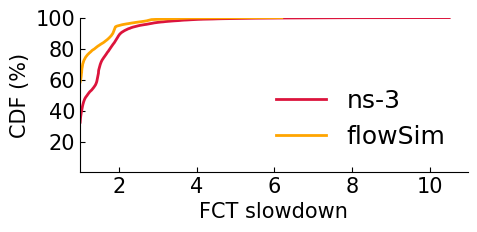

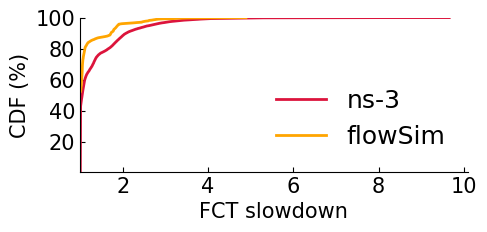

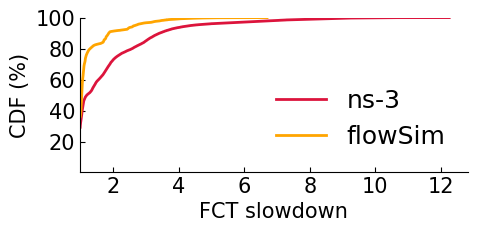

In [2]:
# size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
# size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
size_bins = [0, np.inf]  # Sizes in bytes
size_bin_labels = ['all']
legend_list=['ns-3','flowSim']
model_instance_list=['flowsim']
n_methods = len(legend_list)
empirical_str = f"eval_test"

fig_index=0
for scenario_idx in [60,87,21]:
    fid=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fid_topology_flows.npy')
    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy')[fid]
    
    time_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test/{scenario_idx}/ns3/log_sim.txt'
    with open(time_file) as f:
        lines = f.readlines()
        if lines:  # Check if the file is not empty
            last_line = lines[-1]
            print("Runtime (h):", float(last_line.strip())/60)
        else:
            print("The file is empty.")
    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :len(sizes), 0]
        actual_sldns = sldn[scenario_idx,:len(sizes), 1]
        # print(f"waste: {np.mean(sldn[scenario_idx, len(sizes):, 0])}, {np.mean(sldn[scenario_idx, len(sizes):, 1])}")
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_data=np.array(plot_data)
        error_mean=np.mean(abs(plot_data[0]-plot_data[1])/plot_data[0])*100
        sldn_p99_gt=np.percentile(plot_data[0],99)
        sldn_p99_pred=np.percentile(plot_data[1],99)
        error_p99=abs(sldn_p99_gt-sldn_p99_pred)/sldn_p99_gt*100
        print(f"{size_bin_label}: {len(plot_data[0])}, mean: {error_mean}, p99: {error_p99} ({sldn_p99_gt} {sldn_p99_pred})")
        plot_cdf(plot_data,f'./figs/eva_pre_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=1,log_switch=False,xlim_bottom=1, fig_idx=fig_index)
        fig_index+=1

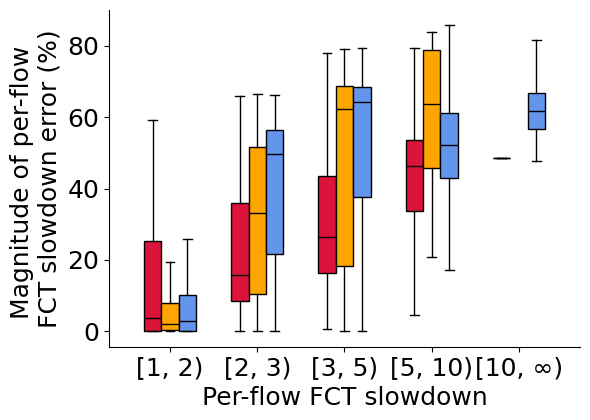

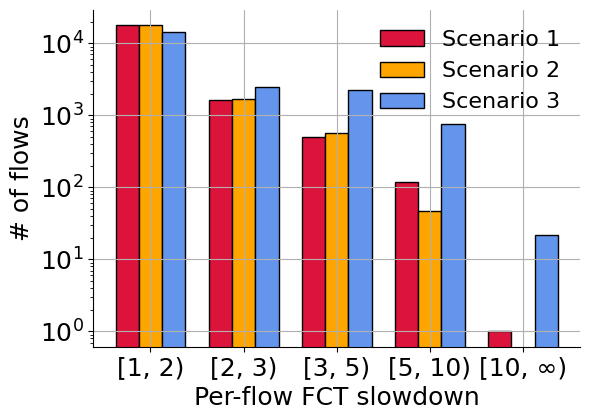

In [5]:
import numpy as np

slowdown_bins = [1, 2, 3, 5, 10, float('inf')]
slowdown_bin_labels = ['[1, 2)', '[2, 3)', '[3, 5)', '[5, 10)', '[10, ∞)']
model_instance_list = ['flowsim']
empirical_str = "eval_test"

# Initialize storage for errors and flow counts
scenario_errors = {scenario: {label: [] for label in slowdown_bin_labels} for scenario in [60, 87, 21]}
scenario_flow_counts = {scenario: {label: 0 for label in slowdown_bin_labels} for scenario in [60, 87, 21]}

# Process each scenario
for scenario_idx in [60, 87, 21]:
    sizes = np.load(
        f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy'
    )

    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0]
        actual_sldns = sldn[scenario_idx, :, 1]

        predicted_sldns[predicted_sldns < 1] = 1
        actual_sldns[actual_sldns < 1] = 1

        # Calculate relative errors
        errors = abs(predicted_sldns - actual_sldns) / actual_sldns * 100
        slowdown_indices = np.digitize(actual_sldns, slowdown_bins, right=False)

        for b in range(1, len(slowdown_bins)):
            bin_mask = slowdown_indices == b
            bin_errors = errors[bin_mask]
            bin_flow_count = np.sum(bin_mask)

            scenario_errors[scenario_idx][slowdown_bin_labels[b - 1]].extend(bin_errors)
            scenario_flow_counts[scenario_idx][slowdown_bin_labels[b - 1]] += bin_flow_count


# Prepare data for plots
# Boxplot data
bucketed_data = [[scenario_errors[scenario][label] for scenario in [60, 87, 21]] for label in slowdown_bin_labels]

# Bar plot data
flow_counts = [[scenario_flow_counts[scenario][label] for scenario in [60, 87, 21]] for label in slowdown_bin_labels]
flow_counts = list(zip(*flow_counts))  # Transpose to match bar plot input format

# Plot the grouped boxplots for relative errors
plot_grouped_boxplots(
    bucketed_data=bucketed_data,
    bucket_labels=slowdown_bin_labels,
    # scenario_labels=['Scenario 1', 'Scenario 2', 'Scenario 3'],
    file_name="./figs/prev_boxplot_errors.pdf",
    # title="Relative Error Distribution by Slowdown Range Across Scenarios",
    x_label="Per-flow FCT slowdown",
    y_label="Magnitude of per-flow \nFCT slowdown error (%)",
    fontsize=18,
    legend_font=13,
    loc=2,
    fig_size=(6, 4.3),
    y_ticklabel_fontsize=18,
)

# Plot the bar chart for flow counts
plot_bars(
    data=flow_counts,
    x_labels=slowdown_bin_labels,
    file_name="./figs/prev_bar_flow_counts.pdf",
    bar_labels=['Scenario 1', 'Scenario 2', 'Scenario 3'],
    x_label="Per-flow FCT slowdown",
    y_label="# of flows",
    figsize=(6, 4.3),
    fontsize=18,
    legend_font=16,
    log_switch=True,
    loc=1,
    # title="Number of Flows by Slowdown Range Across Scenarios",
)
